In [127]:
# import relevant packages
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import statsmodels.api as sm

import yfinance as yf
import arch
import pmdarima as pm

# useful settings for ipynb
import warnings
warnings.simplefilter('ignore')

In [128]:
# download apple daily stock price from Yahoo finance
df=yf.download("AAPL")# start="2000-01-01", end="2019-01-01")

[*********************100%***********************]  1 of 1 completed


In [129]:
# calculate log returns and remove NaNs
df['Log returns daily'] = 100*np.log(df['Adj Close']/(df['Adj Close'].shift(1)))
df = df.dropna()

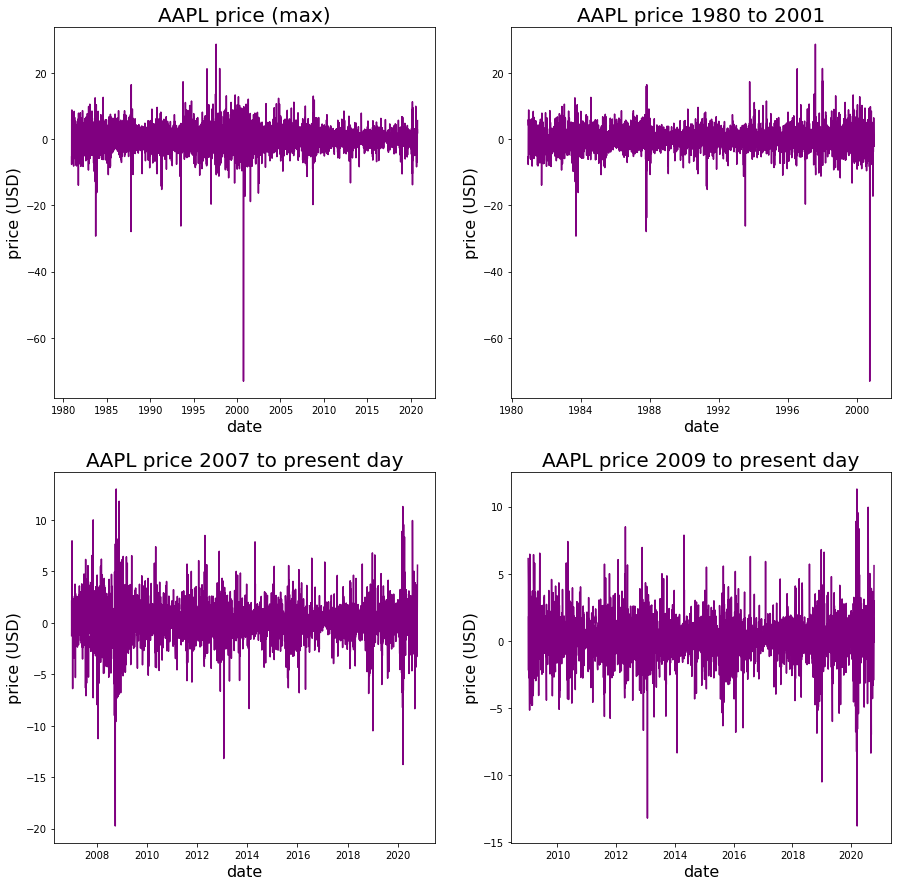

In [130]:
# plot ranges of log returns for AAPLE
# planning to use adj close price for forecast
#fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(15, 15))
fig, ax = plt.subplots(2,2,figsize=(15, 15))
ax[0,0].plot(df['Log returns daily'], color='purple')
ax[0,1].plot(df['Log returns daily'].loc['1980-1-1':'2001-1-1'], color='purple')
ax[1,0].plot(df['Log returns daily'].loc['2007-1-1':], color='purple')
ax[1,1].plot(df['Log returns daily'].loc['2009-1-1':], color='purple')

# set plot titles
ax[0,0].set_title('AAPL price (max)', fontsize=20)
ax[0,1].set_title('AAPL price 1980 to 2001', fontsize=20)
ax[1,0].set_title('AAPL price 2007 to present day', fontsize=20)
ax[1,1].set_title('AAPL price 2009 to present day', fontsize=20)

# set axes labels
for i in range(0,ax.shape[0]):
    for j in range(0,ax.shape[1]):
        ax[i,j].set_xlabel('date',fontsize=16)
        ax[i,j].set_ylabel('price (USD)', fontsize=16)

# chore: axes titles, plot titles (AAPL price from <date range>)

The time series over entire history of stock shows constant mean (0) but contains volatility spikes. This means that a linear model can be used but it is better to use an ARCH type model to account for the heteroscedasticity. Note that the volatility spikes tend to coincide with major financial crises e.g. 1987 stock market crash, dotcom burst (2000), subprime mortgage crisis (2008) etc.

In [131]:
# redefine range of time series to be from 2009 - present 
# df = df['Log returns daily'].loc['2009-1-1':'2019-6-1']
df = df['Log returns daily'].loc['2007-1-1':]

Is the time series stationary? 

In [132]:
# define time series for various levels of differences d = 0-2
df_d0 = df
df_d1 = df.diff().dropna()
df_d2 = df_d1.diff().dropna()
df_d3 = df_d2.diff().dropna()

Text(0.5, 0.98, 'ACF/PACF for TS with d = 0')

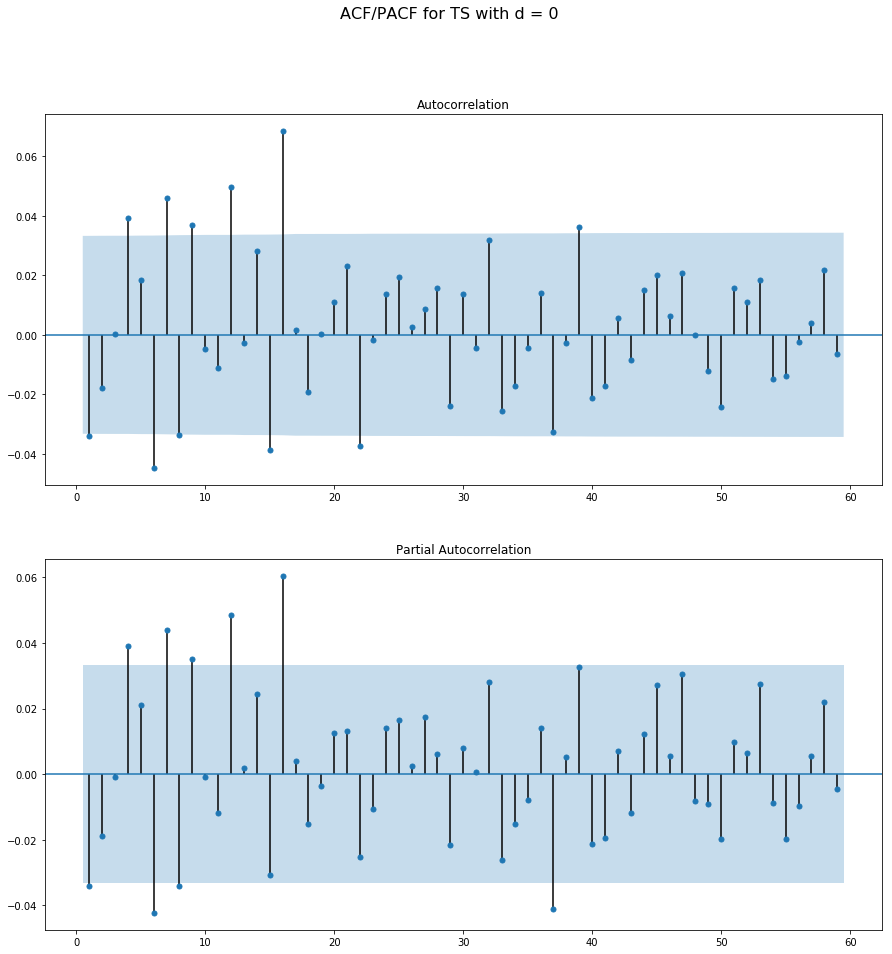

In [133]:
# plot ACF/PACF for original time series
fig, (ax1, ax2) = plt.subplots(2,figsize=(15, 15))
sm.graphics.tsa.plot_acf(df, ax1, lags=np.arange(1,60));
sm.graphics.tsa.plot_pacf(df, ax2, lags=np.arange(1,60));
fig.suptitle('ACF/PACF for TS with d = 0', fontsize=16)

Text(0.5, 0.98, 'ACF/PACF for TS with d = 1')

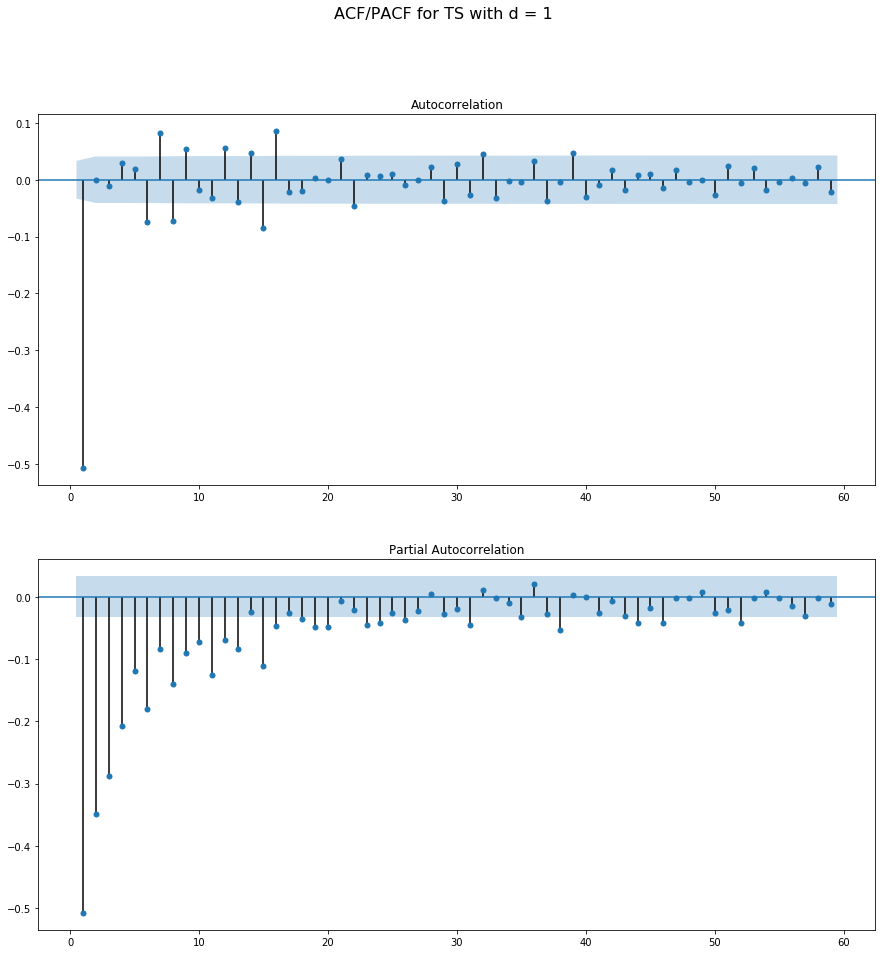

In [134]:
# plot ACF/PACF for first difference of time series
fig, (ax1, ax2) = plt.subplots(2,figsize=(15, 15))
sm.graphics.tsa.plot_acf(df_d1, ax1, lags=np.arange(1,60));
sm.graphics.tsa.plot_pacf(df_d1, ax2, lags=np.arange(1,60));
fig.suptitle('ACF/PACF for TS with d = 1', fontsize=16)

almost looks like an ARIMA(0,1,1) process

Text(0.5, 0.98, 'ACF/PACF for TS with d = 2')

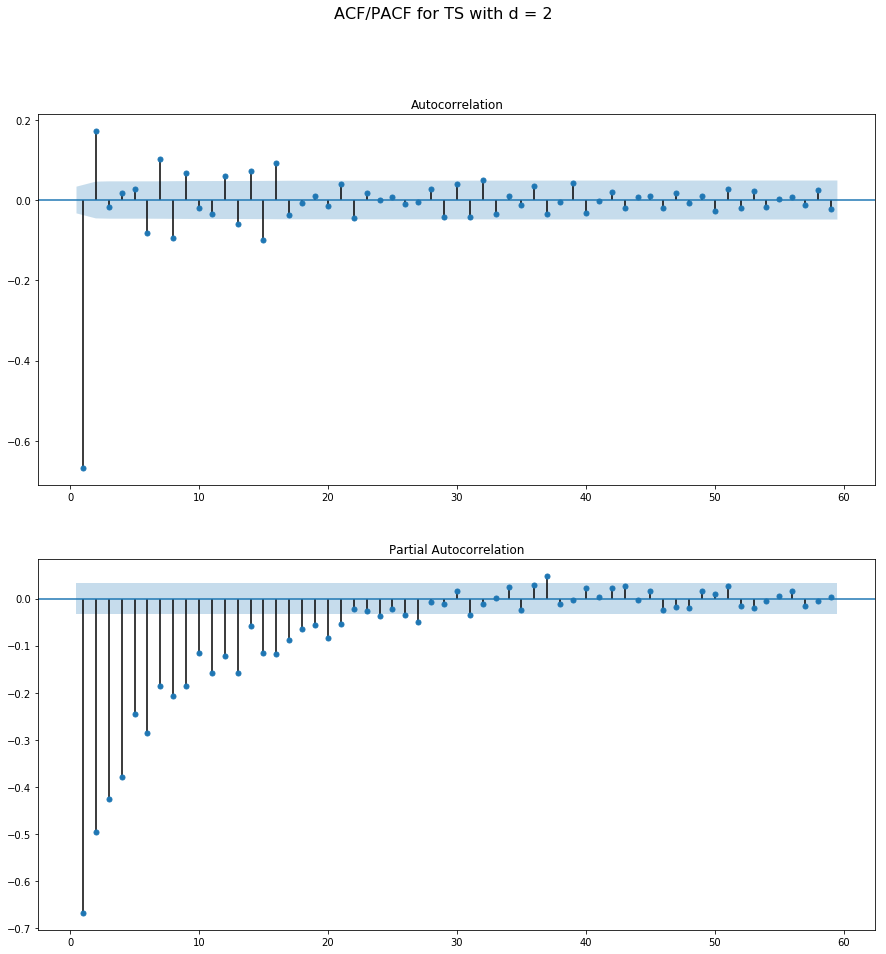

In [90]:
# plot ACF/PACF for second difference of time series
fig, (ax1, ax2) = plt.subplots(2,figsize=(15, 15))
sm.graphics.tsa.plot_acf(df_d2, ax1, lags=np.arange(1,60));
sm.graphics.tsa.plot_pacf(df_d2, ax2, lags=np.arange(1,60));
fig.suptitle('ACF/PACF for TS with d = 2', fontsize=16)

In [91]:
# perform stationarity tests (ADF) additionally print out normality statistics
dftest = sm.tsa.stattools.adfuller(df.values)
dftest_output = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key, value in dftest[4].items():
    dftest_output['Critical Value (%s)'%key] = value
print(dftest_output)

Test Statistic                -1.316940e+01
p-value                        1.259438e-24
#Lags Used                     1.500000e+01
Number of Observations Used    3.453000e+03
Critical Value (10%)          -2.567216e+00
Critical Value (5%)           -2.862377e+00
Critical Value (1%)           -3.432245e+00
dtype: float64


In [92]:
# perform stationarity tests (KPSS)
dftest1 = sm.tsa.stattools.kpss(df)
dftest1_out = pd.Series(dftest1[0:3], index=['Test Statistic','p-value','#Lags used'])
for key, value in dftest1[3].items():
    dftest1_out['Critical Value (%s)'%key] = value
print(dftest1_out)

Test Statistic            0.058762
p-value                   0.100000
#Lags used               30.000000
Critical Value (10%)      0.347000
Critical Value (2.5%)     0.574000
Critical Value (5%)       0.463000
Critical Value (1%)       0.739000
dtype: float64


Comments: original TS is stationary according to both ADF and KPSS. First order difference TS looks like it might be an ARMA(0,1) process

Determine optimal parameters p, q for ARMA(p,q)

In [93]:
model = pm.auto_arima(df,
                      start_p=1, start_q=1,                             
                      max_p=5, max_q=5, max_d=2,                             
                      seasonal=False, max_order = 10,                            
                      d=0, trace=True,           
                      error_action='ignore',  # don't want to know if an order does not work                         
                      suppress_warnings=True,  # don't want convergence warnings   
                      stepwise=True)  # set to stepwise


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=14853.294, Time=0.37 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=14853.083, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=14851.751, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=14851.646, Time=0.07 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=14852.970, Time=0.16 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=14849.415, Time=0.55 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=14854.771, Time=0.53 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=14856.956, Time=0.28 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=14854.812, Time=0.18 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=14854.876, Time=0.35 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=14849.305, Time=1.71 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=14856.064, Time=0.83 sec
 ARIMA(2,0,4)(0,0,0)[0]             : AIC=inf, Time=1.63 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=14857.807, Time=0.74 sec
 ARIMA(3,0,2)(0,0,0)[0]  

In [94]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3469
Model:               SARIMAX(3, 0, 2)   Log Likelihood               -7411.018
Date:                Mon, 12 Oct 2020   AIC                          14836.035
Time:                        18:11:29   BIC                          14879.096
Sample:                             0   HQIC                         14851.410
                               - 3469                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2442      0.073      3.337      0.001       0.101       0.388
ar.L1         -0.1359      0.024     -5.777      0.000      -0.182      -0.090
ar.L2         -0.9607      0.018    -52.042      0.0

In [95]:
model = sm.tsa.arima.ARIMA(df, order=(3,0,2))
model = model.fit()

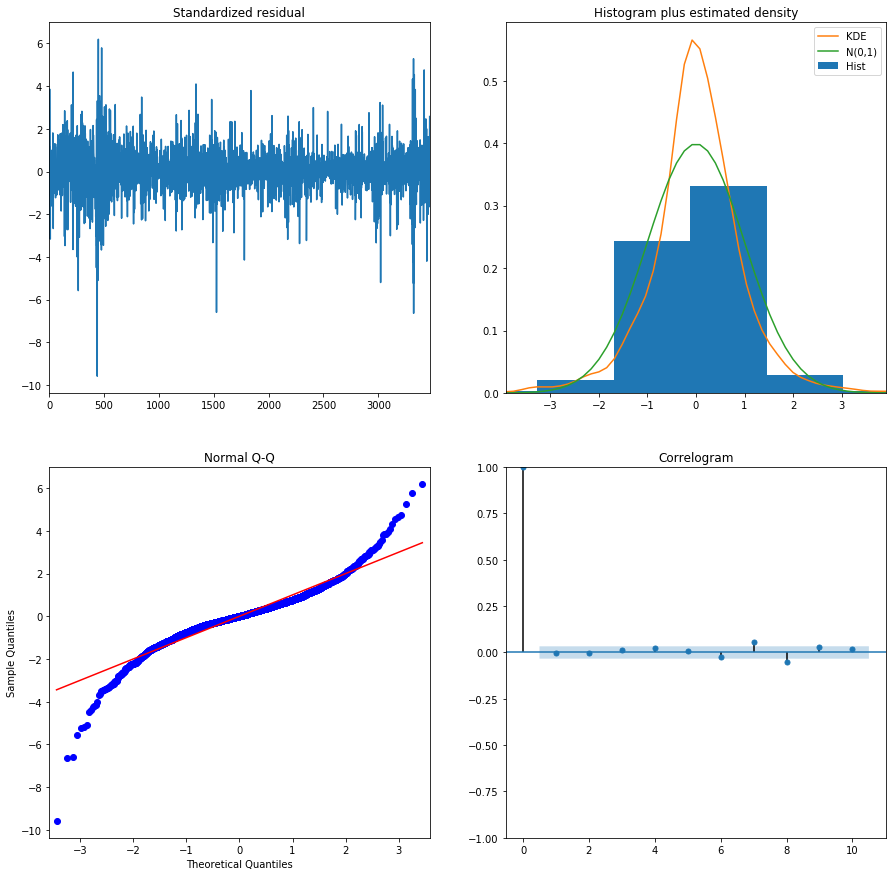

In [103]:
model.plot_diagnostics(figsize=(15,15));

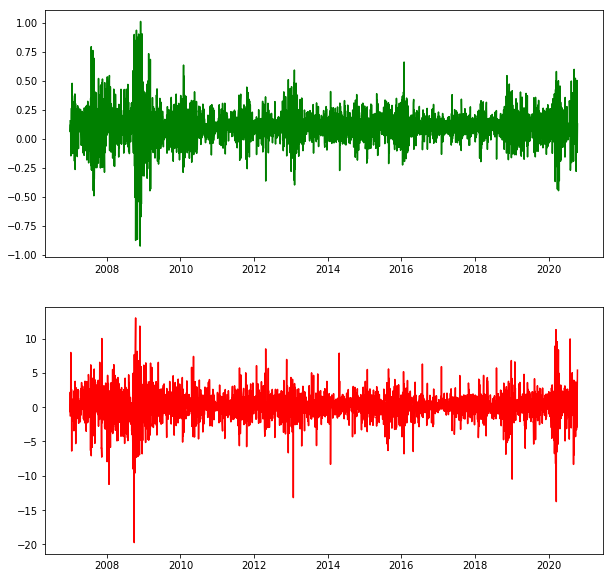

In [102]:
fig, ax = plt.subplots(2, figsize=(10,10))
ax[0].plot(model.predict(1),color = 'green')
ax[1].plot(df, color = 'red')

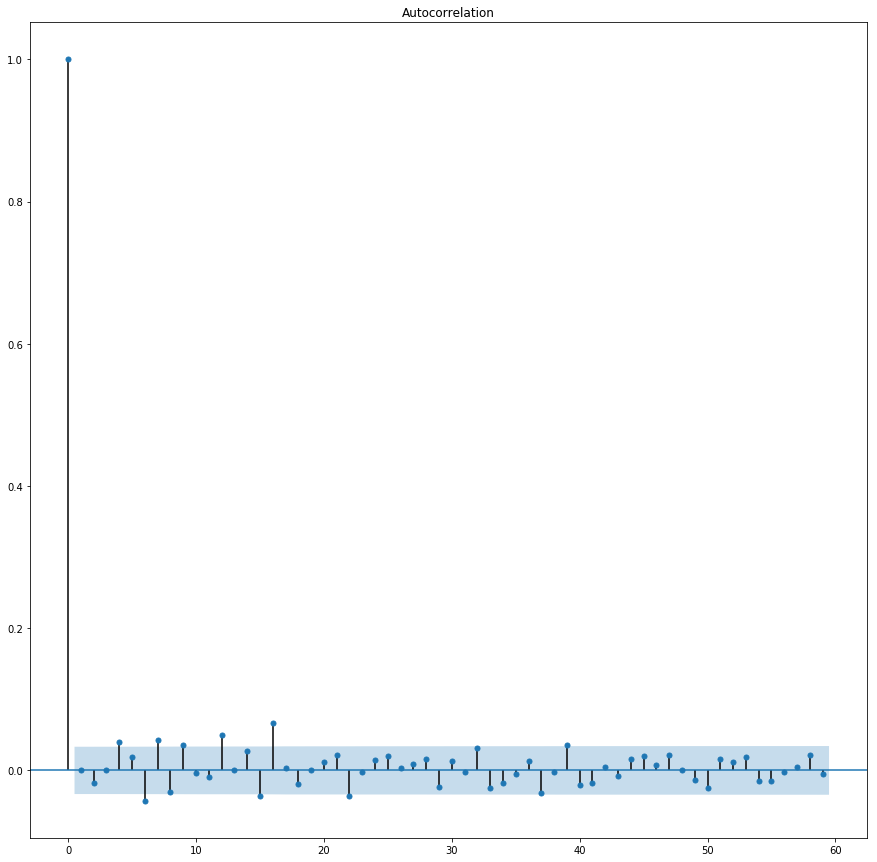

In [24]:
fig, ax1 = plt.subplots(1,figsize=(15, 15))
sm.graphics.tsa.plot_acf(model.resid, ax1, lags=np.arange(0,60));

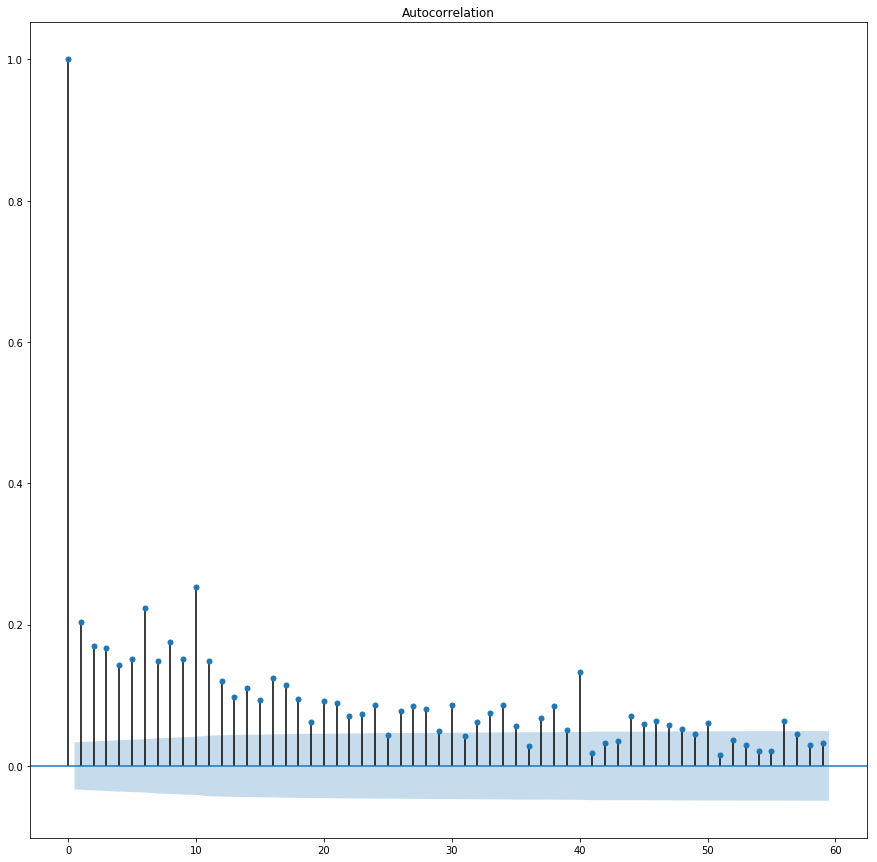

In [25]:
fig, ax1 = plt.subplots(1,figsize=(15, 15))
sm.graphics.tsa.plot_acf(model.resid**2, ax1, lags=np.arange(0,60));

i.e. heteroscedastic behaviour

determine p and q parameters in GARCH for conditional variance

In [104]:
# p and q are stored in the indices of GARCH_array while the values in the GARCH[i,j] correspond to the AIC
min_p = 1
max_p = 5
min_q = 0
max_q = 5
GARCH_array = np.zeros((max_p,max_q))
for i in range(min_p,max_p): # this is the range of p values to be tested
    for j in range(min_q,max_q): # range of q values to be tested
        garch_model = arch.arch_model(model.resid, p=i, q=j,vol='GARCH'); # GARCH model can be specified here
        GARCH_array[i,j] = garch_model.fit(update_freq=10).aic;
        
GARCH_AIC_summary = pd.DataFrame(GARCH_array)

Iteration:     10,   Func. Count:     60,   Neg. LLF: 7242.032160327739
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 7242.032160327571
            Iterations: 10
            Function evaluations: 60
            Gradient evaluations: 10
Iteration:     10,   Func. Count:     73,   Neg. LLF: 6958.269324965013
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6958.269324392693
            Iterations: 10
            Function evaluations: 74
            Gradient evaluations: 10
Iteration:     10,   Func. Count:     84,   Neg. LLF: 6958.242796866278
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6958.225228109608
            Iterations: 14
            Function evaluations: 112
            Gradient evaluations: 14
Iteration:     10,   Func. Count:     92,   Neg. LLF: 6958.52775014392
Optimization terminated successfully.    (Exit mode 0)
            Current functio

In [105]:
GARCH_AIC_summary = GARCH_AIC_summary.iloc[1:] # delete first row corresponding to p = 0 which is not allowed

In [106]:
GARCH_AIC_summary

,0,1,2,3,4
1,14490.064321,13924.538649,13926.450456,13928.111575,13929.367662
2,14316.503465,13926.538650,13928.450457,13929.686879,13929.607444
3,14204.348867,13928.538649,13930.450457,13929.757232,13930.923061
4,14160.181317,13930.538649,13932.450459,13931.757232,13932.923061


In [123]:
garch11 = arch.arch_model(model.resid, p=1, q=2,vol='GARCH')
garch11 = garch11.fit()
print(garch11.summary())

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6975.559079093454
Iteration:      2,   Func. Count:     18,   Neg. LLF: 6974.271703709957
Iteration:      3,   Func. Count:     28,   Neg. LLF: 6971.779975525016
Iteration:      4,   Func. Count:     37,   Neg. LLF: 6969.958487661386
Iteration:      5,   Func. Count:     45,   Neg. LLF: 6962.935012946072
Iteration:      6,   Func. Count:     53,   Neg. LLF: 6961.985788859598
Iteration:      7,   Func. Count:     61,   Neg. LLF: 6959.0959188668585
Iteration:      8,   Func. Count:     69,   Neg. LLF: 6958.897441410709
Iteration:      9,   Func. Count:     77,   Neg. LLF: 6958.355939591054
Iteration:     10,   Func. Count:     84,   Neg. LLF: 6958.242796866278
Iteration:     11,   Func. Count:     91,   Neg. LLF: 6958.226936096002
Iteration:     12,   Func. Count:     98,   Neg. LLF: 6958.225280687764
Iteration:     13,   Func. Count:    105,   Neg. LLF: 6958.225242047278
Iteration:     14,   Func. Count:    112,   Neg. LLF: 6958.2252

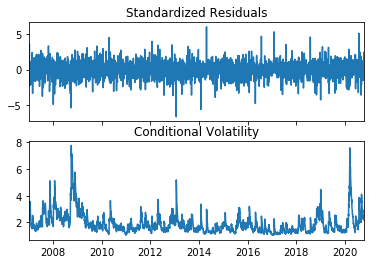

In [124]:
garch11.plot();

In [126]:
garch11.resid

Date
2007-01-03   -1.428138
2007-01-04    1.954978
2007-01-05   -0.859674
2007-01-08    0.283739
2007-01-09    7.838689
2007-01-10    4.727516
2007-01-11   -1.183251
2007-01-12   -1.264439
2007-01-16    2.284930
2007-01-17   -2.588192
2007-01-18   -6.569956
2007-01-19   -0.842258
2007-01-22   -2.425215
2007-01-23   -1.827448
2007-01-24    1.144309
2007-01-25   -0.478913
2007-01-26   -1.471683
2007-01-29    0.266913
2007-01-30   -0.414727
2007-01-31    0.105556
2007-02-01   -1.566308
2007-02-02   -0.314636
2007-02-05   -0.964989
2007-02-06    0.057295
2007-02-07    1.956622
2007-02-08   -0.113738
2007-02-09   -3.406054
2007-02-12    1.639272
2007-02-13   -0.611395
2007-02-14    0.455544
                ...   
2020-08-31    3.237375
2020-09-01    4.013998
2020-09-02   -2.241779
2020-09-03   -8.684002
2020-09-04   -0.297920
2020-09-08   -7.256721
2020-09-09    3.227276
2020-09-10   -3.360103
2020-09-11   -1.475363
2020-09-14    2.692698
2020-09-15   -0.163900
2020-09-16   -3.134441
2020-0

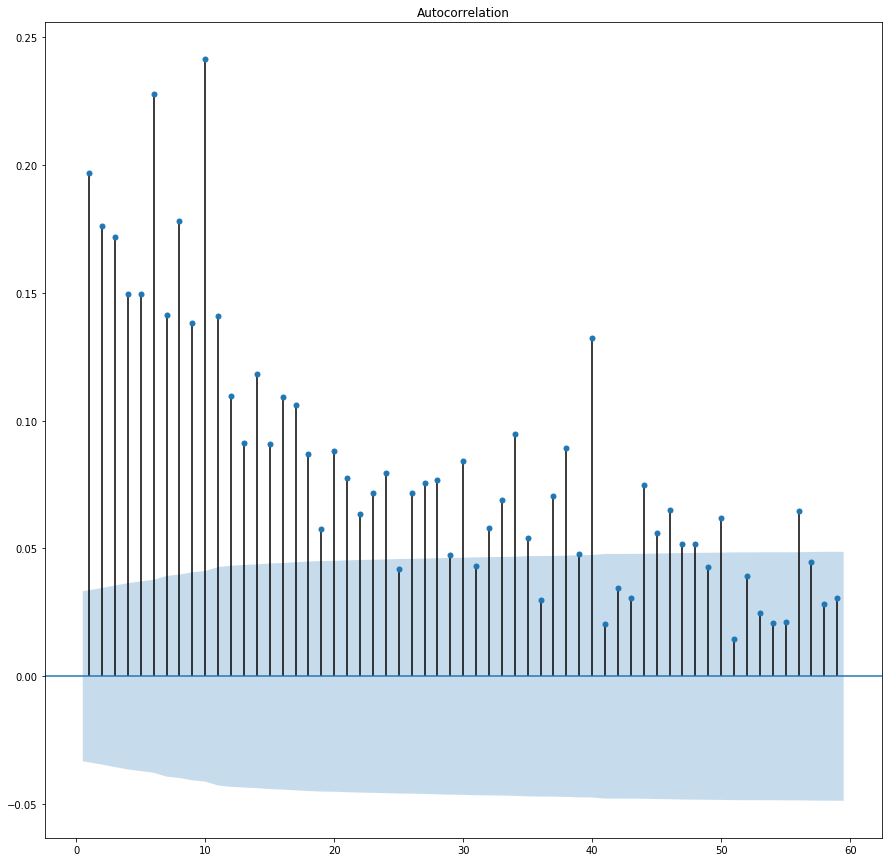

In [120]:
fig, ax1 = plt.subplots(1,figsize=(15, 15))
sm.graphics.tsa.plot_acf(garch11.resid**2, ax1, lags=np.arange(1,60));